# Setup

In [1]:
from truthnet import truthnet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.stats.api as sms
from tqdm.notebook import tqdm
import tikzplotlib as tpl
from datetime import datetime
from IPython.display import display, HTML
import glob
from zedstat import zedstat

from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import (
    ExtraTreesClassifier,
    RandomForestClassifier,
)
from sklearn.metrics import (
    PrecisionRecallDisplay,
    RocCurveDisplay,
    auc,
    mean_squared_error,
    precision_recall_curve,
    r2_score,
    roc_curve,
    roc_auc_score,
)
from sklearn.model_selection import train_test_split
import optuna

# optuna.logging.set_verbosity(optuna.logging.WARNING)

In [ ]:
def _bondDissonance():
    bond = truthnet()
    features, samples = bond.load_data(datapath="data/bondcourt.csv")
    bond.fit(modelpath="tmp_Qnet.joblib")

    time = str(datetime.now())

    bond.getDissonance(
        outfile="data/bondcourt/bondcourt_dissonance_matrix" + time + ".csv"
    )

    return bond

In [14]:
bond = truthnet()
features, samples = bond.load_data(datapath="data/bondcourt.csv")
bond.fit(modelpath="tmp_Qnet.joblib")

bond.getDissonance(outfile="data/bondcourt/bondcourt_dissonance_matrix.csv")

In [18]:
suspects = bond.getSuspects(alpha=0.05)
suspects.join(pd.read_csv("data/bondcourt.csv"))

,mean_dissonance,11713,6294,6295,6296,6297,6298,6299,6300,6301,...,6456,6457,6458,6459,6460,6461,6462,6463,6464,6465


## Diss. vs. response durations

In [8]:
bond_diss = pd.read_csv("data/bondcourt/bondcourt_dissonance_matrix.csv")

bond_durations = pd.read_csv("data/bondcourt/CCHHS_SUD_durations.csv")[
    pd.read_csv("data/bondcourt/bondcourt_dissonance_matrix.csv").columns
]

dd = pd.merge(
    bond_diss,
    pd.melt(bond_durations.reset_index(names="subject"), id_vars="subject"),
    how="left",
    on=["subject", "variable"],
    suffixes=("_diss", "_dur"),
)

In [10]:
dd_q = dd.query("value_dur.notna() & value_dur < 70 & value_diss > 0")
dd_q["value_dur"].corr(dd_q["value_diss"])

0.10967728183505229

In [45]:
def _diss_duration_corr(diss_matrix, n_head=100):
    bond_diss = pd.melt(diss_matrix.reset_index(names="subject"), id_vars="subject")

    dd = pd.merge(
        bond_diss,
        pd.melt(bond_durations.reset_index(names="subject"), id_vars="subject"),
        how="left",
        on=["subject", "variable"],
        suffixes=("_diss", "_dur"),
    )

    dd_subs = dd.groupby("subject", as_index=False).mean().sort_values(by="value_dur")

    def _get_hcorr(n_head):
        dd_sq = dd_subs.head(n_head)

        return dd_sq["value_dur"].corr(dd_sq["value_diss"])

    def _get_tcorr(n_tail):
        dd_sq = dd_subs.tail(n_tail)

        return dd_sq["value_dur"].corr(dd_sq["value_diss"])

    hcor = [_get_hcorr(i) for i in range(3, n_head)]
    tcor = [_get_tcorr(i) for i in range(3, n_head)]

    return pd.DataFrame({"n": range(3, n_head), "n fastest": hcor, "n slowest": tcor})

<AxesSubplot:xlabel='n', ylabel='value'>

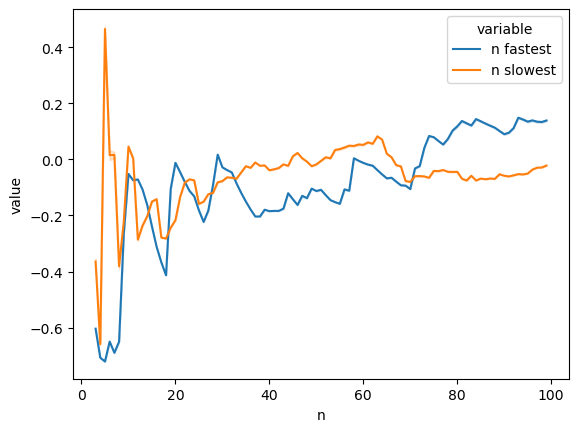

In [46]:
ddc = [
    _diss_duration_corr(pd.read_csv(df))
    for df in glob.glob("data/bondcourt/bondcourt_dissonance*.csv")
]

ddc = pd.melt(pd.concat(ddc), id_vars="n")

sns.lineplot(ddc, x="n", y="value", hue="variable")

In [47]:
conf = 0.95

ddc_ci_var = ddc.groupby(["n", "variable"], as_index=False).agg(
    mean=pd.NamedAgg(column="value", aggfunc="mean"),
    var=pd.NamedAgg(column="value", aggfunc="var"),
    ci=pd.NamedAgg(
        column="value",
        aggfunc=lambda x: sms.DescrStatsW(x).tconfint_mean(alpha=1 - conf),
    ),
)

ddc_ci_var

,n,variable,mean,var,ci
0,3,n fastest,-0.604191,0.000019,"(-0.6073063298304849, -0.601075611232854)"
1,3,n slowest,-0.364610,0.000410,"(-0.3791005439354683, -0.35011870054177474)"
2,4,n fastest,-0.707746,0.000010,"(-0.7100203958885387, -0.7054713213811796)"
3,4,n slowest,-0.659176,0.000071,"(-0.6651852138789708, -0.6531663391601944)"
4,5,n fastest,-0.721375,0.000007,"(-0.7232431511991135, -0.7195072022759541)"
...,...,...,...,...,...
189,97,n slowest,-0.029297,0.000002,"(-0.03024875551031966, -0.028344939066146577)"
190,98,n fastest,0.133912,0.000021,"(0.13067307898053124, 0.13715091804382243)"
191,98,n slowest,-0.028589,0.000004,"(-0.030061725928132138, -0.02711612203131311)"
192,99,n fastest,0.139222,0.000020,"(0.1360317204704076, 0.14241288382257775)"


In [49]:
ddc_ci_var.assign(
    lower=lambda x: [c[0] for c in x["ci"]], upper=lambda x: [c[1] for c in x["ci"]]
).drop("ci", axis="columns").to_csv(
    "data/bondcourt/diss_dur_corr_ci_var.csv", index=False
)

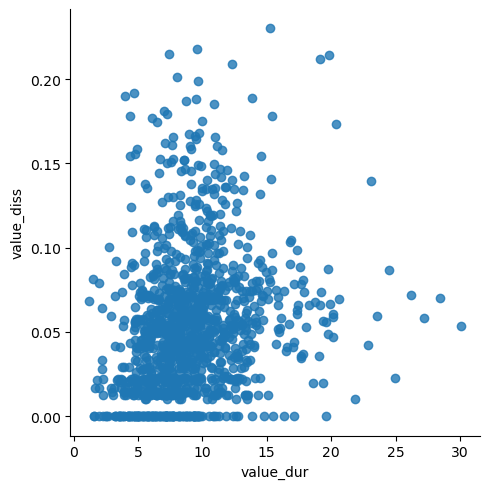

In [15]:
sns.lmplot(dd_subs, x="value_dur", y="value_diss", fit_reg=False)

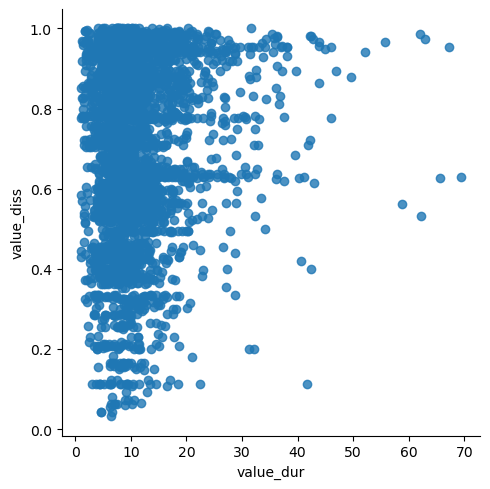

In [7]:
sns.lmplot(
    dd.query("value_dur.notna() & value_dur < 70 & value_diss > 0"),
    x="value_dur",
    y="value_diss",
    fit_reg=False,
)

In [ ]:
sns.lmplot(
    dd.query("value_dur.notna()"),
    x="value_dur",
    y="value_diss",
    fit_reg=False,
    col="variable",
    col_wrap=4,
    sharey=False,
)

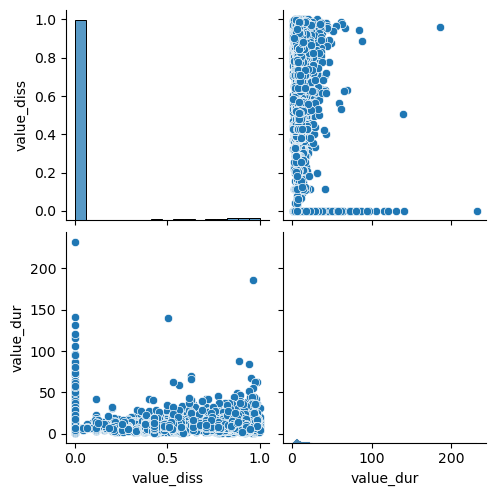

In [38]:
sns.pairplot(
    dd,
    vars=["value_diss", "value_dur"],
)

In [15]:
bond_diss.corrwith(bond_durations).sort_values(ascending=False)

6366    0.595434
6348    0.400497
6393    0.312004
6314    0.275644
6317    0.268343
6394    0.260347
6294    0.254542
6373    0.245749
6412    0.243955
6408    0.234076
6422    0.209906
6391    0.203357
6319    0.195062
6436    0.189549
6352    0.184100
6353    0.176760
6387    0.175391
6328    0.164626
6411    0.152715
6399    0.148577
6315    0.143240
6296    0.139661
6409    0.124043
6385    0.110714
6363    0.095641
6426    0.084970
6392    0.080438
6325    0.020901
6421    0.017634
6400    0.011919
6362   -0.042902
6410   -0.045115
6327   -0.082335
6356   -0.103941
6427   -0.124186
6298         NaN
6326         NaN
6358         NaN
6374         NaN
6382         NaN
6386         NaN
6390         NaN
6463         NaN
6464         NaN
6465         NaN
dtype: float64

-----

------------